# Importing the required libraries

In [1]:
# Core
import pandas as pd                      #Used for data manipulation and analysis.
import numpy as np                       #Used for data manipulation and analysis.
import os                                #Used for removing oe creating a library and also to fetch data. 
import cv2                               #Used for performing image processing task.
import gc                                #Used to free up the memory space by deleting unwanted object.
from PIL import Image                    #Python imaging library for supporting image formats like PNG.
import matplotlib.pyplot as plt          #Used for attractive and interactive visualization plots.




from glob import glob                    #Used for returning file paths from specific directory.

import matplotlib.gridspec as gridspec   #Used for specifying geometry of the image and to later place subplots.
import matplotlib.patches as mpatches    #Used for creating a patches on the plot with a stream of inputs using color and label.
import matplotlib as mpl                 #Used to create 2d graphs and plots. with ListedColormap creates color maps from the list of colors.
from sklearn.model_selection import StratifiedGroupKFold    
                                         #Used mainly to ensure while performing cross validation the feature is present uniformly btw training and test test. 
import random                            #Used to return a random value present in the given list or dictionary.

# Keras
from tensorflow import keras             #Used to perform CNN tasks which runs on top of tensorflow.
import tensorflow as tf                  #Used to perform many ML and CNN tasks.
import keras
from keras import backend as K           #Its a keras Manipulation library under tensorflow.
from keras.models import Model           
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model
from keras.preprocessing.image import ImageDataGenerator                  #Used for performing data augmentations.

#Define the required configurations

BATCH_SIZE = 32
EPOCHS = 50
n_splits = 5
fold_selected = 2   # 1,...,5
im_width = 320
im_height = 320

# Extracting the data for Training and Testing set from the kaggle site.

**Training set**

In [4]:
# Train set
tr_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')  #reading the csv file.
print(f"The training data set shape is {tr_df.shape}")                         #finding the shape of the dataframe (rows and cols).


(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
tr_df.head()    #Displays first 5 rows in the dataframe.

**Testing set**

In [5]:
# Test set
test_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
test_df = tr_df.iloc[:480,:]
test_df["segmentation"]=''
test_df=test_df.rename(columns={"segmentation":"predicted"})

test_df.head()

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


# Preprocessing of the dataframe

In [6]:

def preprocessing(df, subset="train"):
    #--------------------------------------------------------------------------
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    #--------------------------------------------------------------------------
    DIR="../input/uw-madison-gi-tract-image-segmentation/train"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df

In [7]:
tr_df = preprocessing(tr_df)                  #Preprocessing of training set
tr_df.head()

,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [8]:
test_df=preprocessing(test_df)                         #Preprocessing of testing set
test_df.head()

,id,class,predicted,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


Restructuring of the dataframe

In [9]:
# Restructure
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_out['large_bowel'] = df['segmentation'][::3].values                              #In order to train the model the preprocessed data needs to be restructured.
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
    
    return df_out

In [10]:
tr_df=restructure(tr_df, subset="train")
tr_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266,0


In [11]:
test_df=restructure(test_df, subset="test")
test_df.head()

,id,path,case,day,slice,width,height
0,case123_day20_slice_0001,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266
1,case123_day20_slice_0002,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266
2,case123_day20_slice_0003,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266
3,case123_day20_slice_0004,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266
4,case123_day20_slice_0005,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266


In [13]:

gc.collect()      #for collecting the garbage value to free up memory space from unwanted object data.

106

# Resuable functions (Encoding and Decoding)

**RLE encoding** mainly used for the data compression

In [14]:
# Run-length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

**Metrics used for evaluating the model**

1.)Dice Coefficient.

2.)The Intersection over Union (IoU) metric (Jaccard index).

3.)To calculate the loss **Cross Entropy** is used.

In [15]:
# Metrics
def dice_coef(y_true, y_pred, smooth=1):                                       #Dice coefficient
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])                  #IoU coefficient
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou
                                                                                
def dice_loss(y_true, y_pred):                                                  #Dice loss
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):                                              #Binary cross entropy
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + dice_loss(tf.cast(y_true, tf.float32), y_pred)

**Data generator** for the MRI images in PNG format by broadcasting it into respective shape and perform data augmentation.  

Data augmentation is important as it improves the model performance by creating training datasets from the available data.

In [16]:
# Images reshaped to (im_height,im_width)
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,im_height,im_width,3))
        y = np.empty((self.batch_size,im_height,im_width,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)  # shape: (im_height,im_width,1)
            X[i,] = img   # broadcast to shape: (im_height,im_width,3)
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (im_height,im_width))                            
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
        # To do: add data augmentation

        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)                        #IMREAD_ANYDEPTH is used to read the read the images in any format (PNG,JPG, etc)
        dsize = (im_height,im_width)
        img = cv2.resize(img, dsize)                                           #Chnage the height and width of the image
        img = img.astype(np.float32) / 255.0
        img = ImageDataGenerator(rotation_range=50,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 zoom_range=0.5,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 brightness_range=[0.5, 1.5])
        img = np.expand_dims(img, axis=-1)                                     #To add new dimesions of the data
        return img

# Cross-validation (K-fold) = 2

In [19]:
# Group by case id
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=tr_df, y=tr_df['count'], groups=tr_df['case']), 1):
    tr_df.loc[val_idx, 'fold'] = fold

tr_df['fold'] = tr_df['fold'].astype(np.uint8)

tr_ids = tr_df[tr_df["fold"]!=fold_selected].index
valid_ids = tr_df[tr_df["fold"]==fold_selected].index

X_train = tr_df[tr_df.index.isin(train_ids)]
X_valid = tr_df[tr_df.index.isin(valid_ids)]

tr_df.groupby('fold').size()

fold
1    8160
2    6080
3    8192
4    9152
5    6624
dtype: int64

In [20]:
# 2 Folds with 5 splits.
tr_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        4857
      1         475
      2        2155
      3         673
2     0        3412
      1         294
      2        1793
      3         581
3     0        4622
      1         537
      2        2278
      3         755
4     0        5160
      1         744
      2        2596
      3         652
5     0        3718
      1         396
      2        2012
      3         498
Name: id, dtype: int64

In [21]:
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (32128, 12)
X_valid shape: (6080, 12)


**Generating data from the generator function**

In [22]:
tr_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

# U-Net model

**Downloading U-Net segmentation models**

In [ ]:
! pip install segmentation-models

In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models

In [25]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

**Define model**

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('resnet50',input_shape=(im_height, im_width, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')  #creating and instances of the model using hyperparameters
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef])

In [27]:
# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 320, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 160, 160, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

# Training model

**Callbacks**

In [28]:
# Save best model at every epoch
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

# Stop early if no improvement seen
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

# Cosine decay

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=2e-3,
    decay_steps=EPOCHS + 2, 
    alpha=0,
)
lr_schedule = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)

# Reduce learning rate on plateau
lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    min_delta=0.0001,
)

**Train model**

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, 
               #early_stopping, 
               lr_plateau],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

**Learning curves**

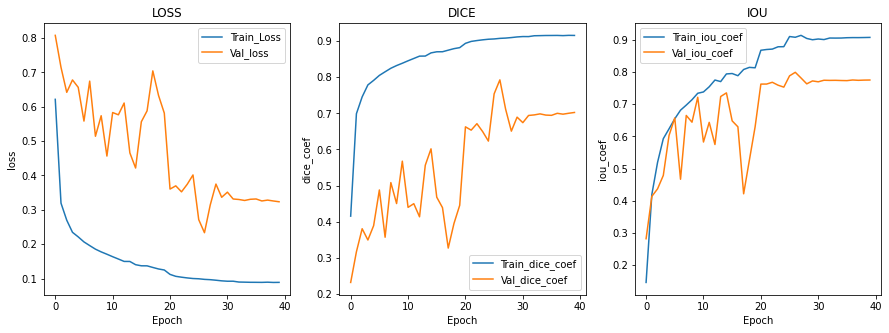

In [30]:
# History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

# Evaluation

**Save model (if checkpoint not used)**

In [31]:
#save_model(model,'UNET_model')

'''
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}
model = load_model('./UNET_model', custom_objects=custom_objects)
'''

"\ncustom_objects = custom_objects={\n    'dice_coef': dice_coef,\n    'iou_coef': iou_coef,\n    'bce_dice_loss': bce_dice_loss\n}\nmodel = load_model('./UNET_model', custom_objects=custom_objects)\n"

**Preview predictions**

8/8 [==============================] - 1s 12ms/step


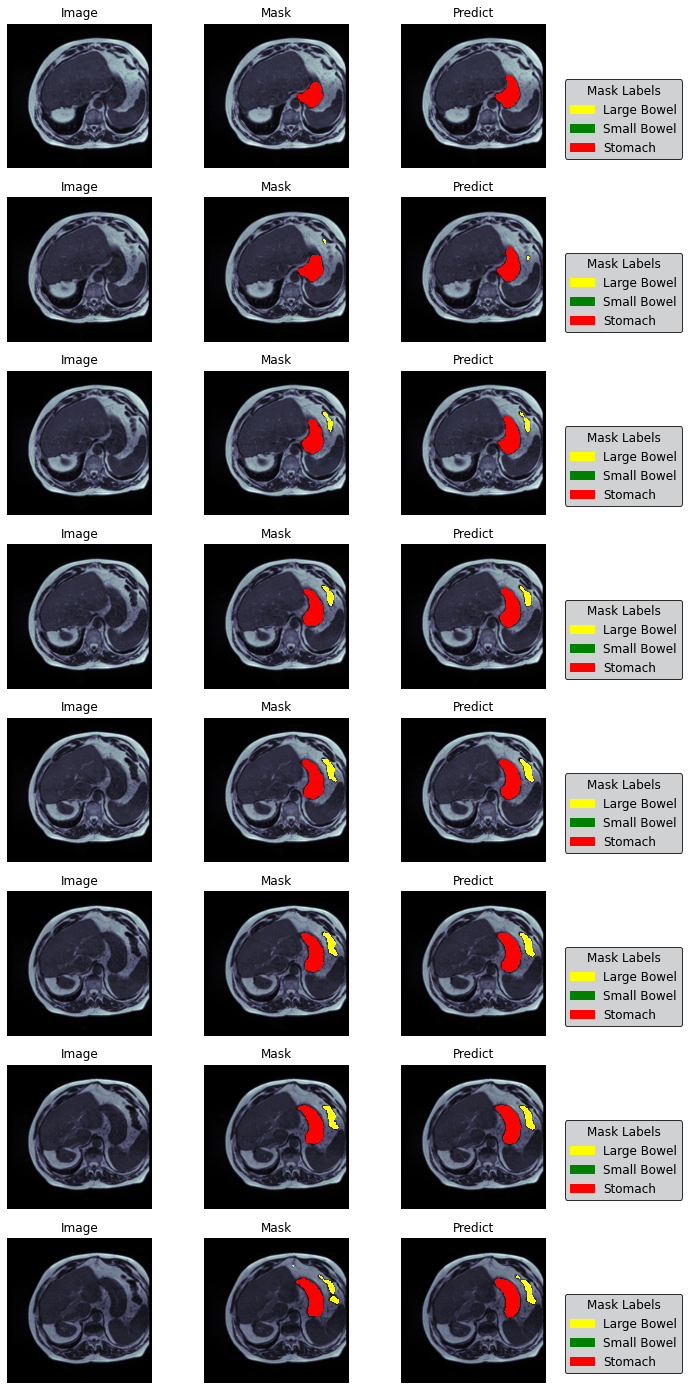

In [32]:
pred_batches = DataGenerator(X_valid.iloc[200:208,:], batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


# Test set predictions

**Make predictions on test set**

In [33]:
#gcd(80,144)=16=BATCH_SIZE
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,im_height,im_width,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'predicted'] = rle_encode(pred_img)

**Save predictions**

In [34]:
submission.to_csv('submission.csv',index=False)
submission.sample(20)                               #In MRI imaging, the organs are not visible, which is why the first few samples cannot be predicted.

,id,class,predicted
153,case123_day20_slice_0052,large_bowel,
138,case123_day20_slice_0047,large_bowel,
134,case123_day20_slice_0045,stomach,
297,case123_day20_slice_0100,large_bowel,
427,case123_day20_slice_0143,small_bowel,
295,case123_day20_slice_0099,small_bowel,
394,case123_day20_slice_0132,small_bowel,
359,case123_day20_slice_0120,stomach,
438,case123_day22_slice_0003,large_bowel,
409,case123_day20_slice_0137,small_bowel,
